In [227]:
import pandas as pd
import numpy as np
from dateutil.parser import parse
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
import seaborn as sns
import plotly.express as px
from scipy.optimize import curve_fit
import math
from scipy.interpolate import splrep, BSpline
from statsmodels.tsa.seasonal import STL
from sklearn.metrics import mean_squared_error
import ruptures as rpt
import warnings
warnings.simplefilter('ignore')
import sys
sys.path.insert(0,'/Users/Kathy/Desktop/UW/seaflow/decomposition_project/scripts/')
from diel_tools import *
from fig_tools import *
from tsd_functions import *
from rate_functions import *
from simulation_tools import *

## Plot Annette's model's growth rate and productivity

In [41]:
# helper function to assign cruise days to dates
def cruise_dates_to_days(df, dates, days):
    # loop and assign
    for date,day in zip(dates,days):
        # assign cruise day based on date
        df.loc[df['date']==date, 'cruise_day']=day
    return df

In [171]:
## look annette's data from her model
annette_df=pd.read_csv('data/SeaFlow_ALOHA_growth_productivity.csv')
annette_df=annette_df.loc[(annette_df['pop']=='prochloro')|(annette_df['pop']=='synecho')]
dfs=[]
# set crusie days for each data
for cruise in pd.unique(annette_df['cruise']):
    # get subdf of cruise
    sub_df=annette_df.loc[annette_df['cruise']==cruise]
    cruise_dates=pd.unique(sub_df['date'])
    # generate cruise days based on number of dates
    cruise_days=np.char.mod('%d', np.arange(1,len(cruise_dates)+1))
    # assign cruise days to dates
    dfs.append(cruise_dates_to_days(annette_df.loc[annette_df['cruise']==cruise], 
                               cruise_dates, cruise_days))
days_df=pd.concat(dfs)

# calculate daily growth by daylength and r
days_df['daily_growth']=days_df['daylength']*days_df['r']
# estimate with error
days_df['daily_se']=days_df['daylength']*days_df['r_se']

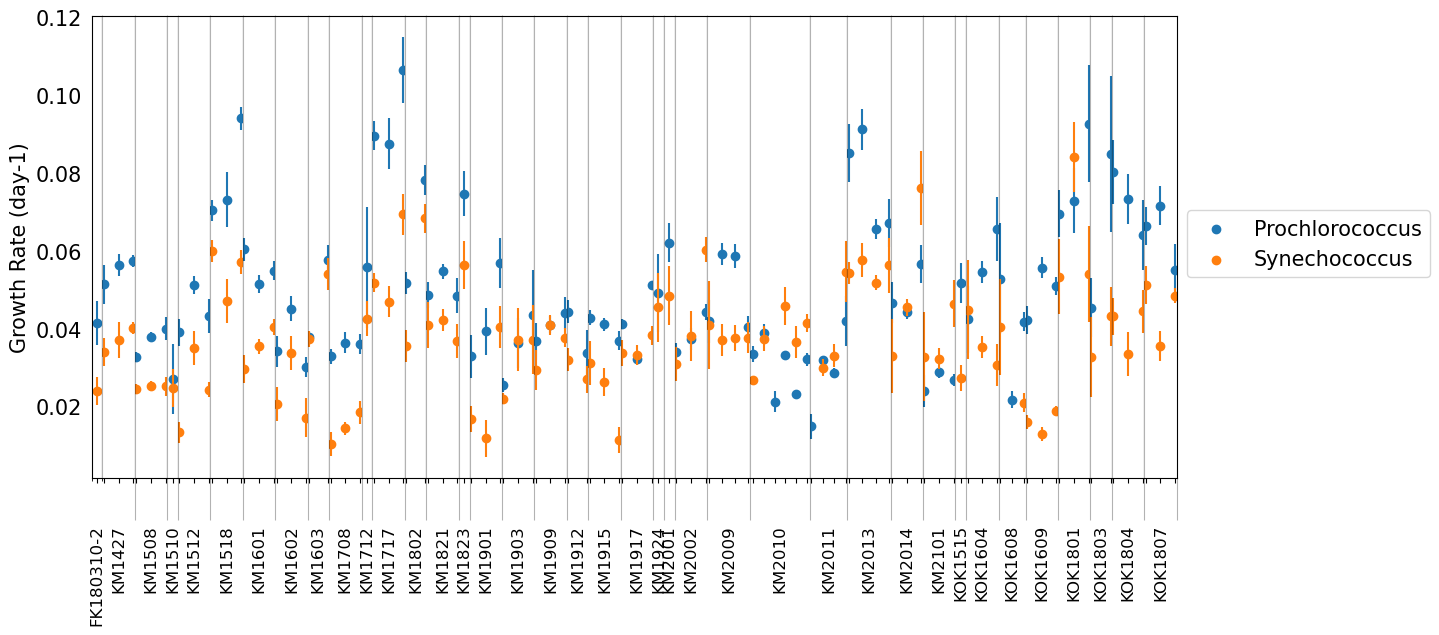

In [187]:
test=days_df.copy()
# sns.lineplot(data=test, x='cruise_day',y='r',hue='pop',marker='o')
# set multi index
test.set_index(['cruise', 'cruise_day'], inplace=True)
# define zones and number of plots
zones = test.index.levels[0]
nplots = zones.size
# define plot width ratio for each zone (cruise)
plots_width_ratios = [test.xs(zone).index.size*3 for zone in zones]
fig, axes = plt.subplots(nrows=1, ncols=nplots, sharey=True, figsize=(14, 6),
                         gridspec_kw = dict(width_ratios=plots_width_ratios, wspace=0))

# Loop through array of axes to create grouped bar chart for each cruise
alpha = 0.3 # used for grid lines, bottom spine and separation lines between zones
count=0
for zone, ax in zip(zones, axes):
    # plot data
    # need seprate matplotlib plots bc seaborn still doesn't do custom error bars :/
    df=test.xs(zone).reset_index()
    pro=df.loc[df['pop']=='prochloro']
    syn=df.loc[df['pop']=='synecho']
    # plot data
    ax.scatter(pro['cruise_day'],pro['r'],label='Prochlorococcus')
    ax.scatter(syn['cruise_day'],syn['r'],label='Synechococcus')
    # add error bars
    ax.errorbar(pro['cruise_day'],pro['r'],yerr=pro['r_se'],ls='none')
    ax.errorbar(syn['cruise_day'],syn['r'],yerr=syn['r_se'],ls='none')
#     sns.scatterplot(data=test.xs(zone), x='cruise_day',y='daily_growth',
#                     hue='pop',ax=ax,legend=None,marker='o',zorder=2,size=1.5)
    
    # adjust spines in the middle
    if count>0:
        ax.spines['left'].set_alpha(alpha)
    
    # Set and place x labels for cruises
    ax.set_xlabel(zone,rotation='vertical',size=12)
    # rotate
    ax.xaxis.set_label_coords(x=0.5, y=-0.1)
    # axis aesthetics
    ax.tick_params(left = False)
    count+=1
    
    # hide cruise days
    ax.tick_params(labelbottom=False) 
    
    #format tick separations
    if ax.is_first_col():
        ax.set_xticks([*ax.get_xlim()], minor=True)
        ax.set_ylabel('Growth Rate (day-1)',size=15)
        ax.tick_params(axis='y', labelsize=15)
    else:
        ax.set_xticks([ax.get_xlim()[1]], minor=True)
        ax.tick_params(which='minor', length=30, width=0.8, color=[0, 0, 0, alpha])
        
# fig.text(0.04, 0.5, 'Growth Rate (hour-1)', va='center', rotation='vertical')
# Add legend using the labels and handles from the last subplot
fig.legend(*ax.get_legend_handles_labels(),frameon=True, loc='center left', bbox_to_anchor=(0.9, 0.5),
          prop={'size': 15})
plt.show()

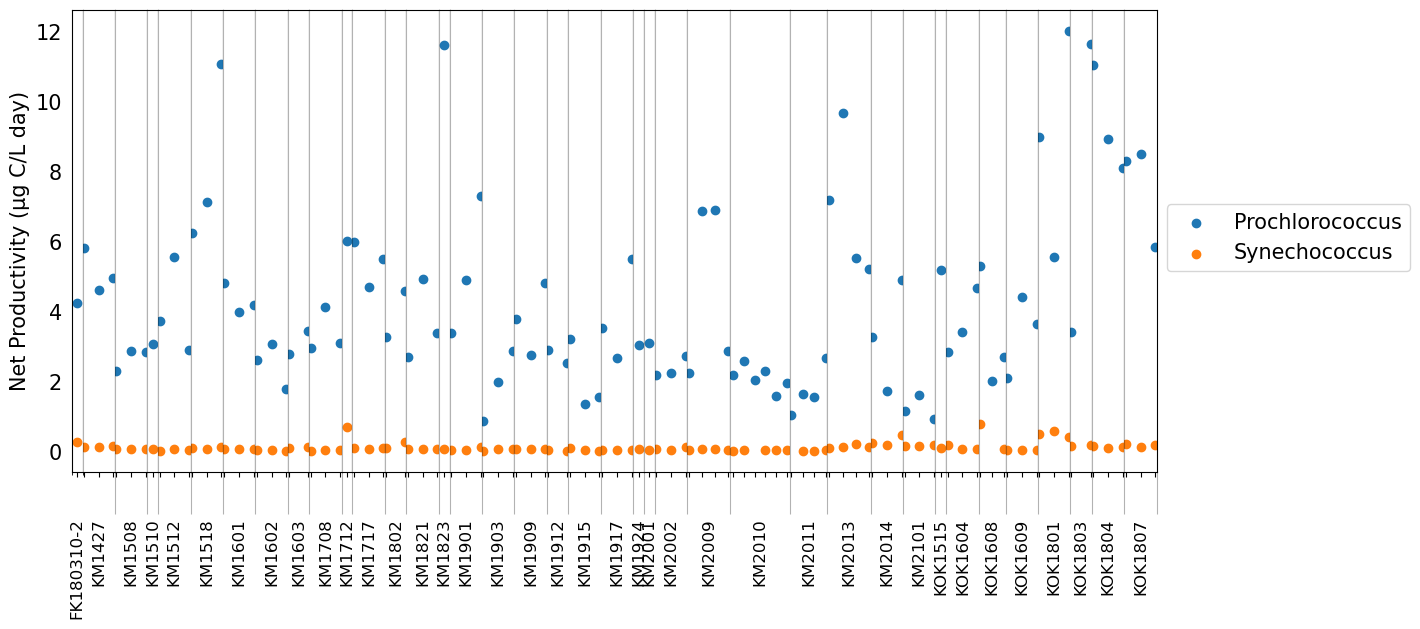

In [195]:
fig, axes = plt.subplots(nrows=1, ncols=nplots, sharey=True, figsize=(14, 6),
                         gridspec_kw = dict(width_ratios=plots_width_ratios, wspace=0))

# Loop through array of axes to create grouped bar chart for each cruise
alpha = 0.3 # used for grid lines, bottom spine and separation lines between zones
count=0
for zone, ax in zip(zones, axes):
    # plot data
    # need seprate matplotlib plots bc seaborn still doesn't do custom error bars :/
    df=test.xs(zone).reset_index()
    pro=df.loc[df['pop']=='prochloro']
    syn=df.loc[df['pop']=='synecho']
    # plot data
    ax.scatter(pro['cruise_day'],pro['PP_exp'],label='Prochlorococcus')
    ax.scatter(syn['cruise_day'],syn['PP_exp'],label='Synechococcus')
    
    # adjust spines in the middle
    if count>0:
        ax.spines['left'].set_alpha(alpha)
    
    # Set and place x labels for cruises
    ax.set_xlabel(zone,rotation='vertical',size=12)
    # rotate
    ax.xaxis.set_label_coords(x=0.5, y=-0.1)
    # axis aesthetics
    ax.tick_params(left = False)
    count+=1
    
    # hide cruise days
    ax.tick_params(labelbottom=False) 
    
    #format tick separations
    if ax.is_first_col():
        ax.set_xticks([*ax.get_xlim()], minor=True)
        ax.set_ylabel('Net Productivity (µg C/L day)',size=15)
        ax.tick_params(axis='y', labelsize=15)
    else:
        ax.set_xticks([ax.get_xlim()[1]], minor=True)
        ax.tick_params(which='minor', length=30, width=0.8, color=[0, 0, 0, alpha])
        
# Add legend using the labels and handles from the last subplot
fig.legend(*ax.get_legend_handles_labels(),frameon=True, loc='center left', bbox_to_anchor=(0.9, 0.5),
          prop={'size': 15})
plt.show()

## Plot TSD estimates of growth rate and productivity
1. Check for missing data
    - Yes, run imputation.
    - No, move to step 2.
2. Check for data length.
    - <3, select Rolling Model.
    - ≥3, select STL Model.
3. Run selected TSD model.
4. Calculate diel growth by exponential cellular growth function.
5. Check for stationarity.
    - Yes, calculate mean trend across time series.
    - No, calculate breakpoints and mean trend per break point.
6. Calculate net productivity by growth and mean trend across dataset of breakpoints.

In [218]:
# load the data
all_cruises = pd.read_csv('/Users/Kathy/Desktop/UW/diel_workshop/PSD_mean_2022-10-20.csv')
all_cruises.rename(columns={'date':'time', 'c_quotas':'diam_med'}, inplace=True)
all_cruises = all_cruises.loc[((all_cruises['pop'] == 'prochloro')) | (all_cruises['pop']== 'synecho')]
all_cruises['time'] = pd.DatetimeIndex(all_cruises['time'].apply(lambda x: parse(x))).tz_convert('UTC')
# read in instrument log
log=pd.read_csv('data/seaflow_log.csv')
# grab only g1 data
cruise_daily=all_cruises.loc[all_cruises['cruise']=='SCOPE_16']
# grab cruises from annette's model
hot_ids=pd.unique(annette_df['cruise'])
hot_names=log.loc[log['Cruise ID'].isin(hot_ids),'cruise'].values
# grab names that correspond to cruise ID
hot_cruises=all_cruises.loc[all_cruises['cruise'].isin(hot_names)]

### Check for missing data
- Run data imputation 

In [239]:
test_cruise

,cruise,time,pop,n_per_uL,c_per_uL,lat,lon,temp,salinity,par,diam_med
21629,SCOPE_1,2014-12-09 00:00:00+00:00,synecho,1.449676,0.313793,21.278942,-157.872142,26.086842,35.150526,1890.987895,0.216458
21630,SCOPE_1,2014-12-09 00:00:00+00:00,prochloro,231.434330,7.958228,21.278942,-157.872142,26.086842,35.150526,1890.987895,0.034387
21633,SCOPE_1,2014-12-09 01:00:00+00:00,synecho,1.675969,0.383521,21.271288,-157.879135,26.084706,35.144706,1688.152353,0.228835
21634,SCOPE_1,2014-12-09 01:00:00+00:00,prochloro,262.065966,10.066712,21.271288,-157.879135,26.084706,35.144706,1688.152353,0.038413
21637,SCOPE_1,2014-12-09 02:00:00+00:00,synecho,1.538817,0.355468,21.246335,-158.018875,26.152500,35.148000,1285.382000,0.231001
...,...,...,...,...,...,...,...,...,...,...,...
21918,SCOPE_1,2014-12-12 00:00:00+00:00,prochloro,239.768525,8.975146,22.674700,-158.032005,25.358500,35.280000,1305.691000,0.037433
21921,SCOPE_1,2014-12-12 01:00:00+00:00,synecho,1.760912,0.373220,22.674395,-158.031790,25.363000,35.280000,1269.245500,0.211947
21922,SCOPE_1,2014-12-12 01:00:00+00:00,prochloro,232.499061,9.135315,22.674395,-158.031790,25.363000,35.280000,1269.245500,0.039292
21925,SCOPE_1,2014-12-12 02:00:00+00:00,synecho,1.802340,0.402486,22.673925,-158.031383,25.355000,35.280000,1558.930833,0.223313


In [235]:
# generate unique hour for each time 
test_cruise.dtypes
pd.DatetimeIndex(test_cruise[-1])

cruise                   object
time        datetime64[ns, UTC]
pop                      object
n_per_uL                float64
c_per_uL                float64
lat                     float64
lon                     float64
temp                    float64
salinity                float64
par                     float64
diam_med                float64
dtype: object

In [229]:
test_cruise=hot_cruises.loc[hot_cruises['cruise']==hot_names[0]]
# also need to split by population!
# show_raw_diel(test_cruise,'diam_med',hot_names[0])
pro=test_cruise[test_cruise['pop']=='prochloro']
pro['']
syn=test_cruise[test_cruise['pop']=='synecho']
# add  column
pro['data_with_missing']=pro['diam_med']
run_imputation(pro,col='diam_med',missing_col='data_with_missing',period=24,interval=1)

KeyError: "None of ['hour'] are in the columns"

In [4]:
# function to run STL model
## input: cruise df
## output: pro_res = dataframe with cleaned tsd components for pro, syn_res=same but with syn
def run_STL(cruise):
    ## preliminary data cleaning 
    # run linear interpolation helper function to fill in missing data
    pro_res = interp_by_time(cruise, 'prochloro')
    syn_res = interp_by_time(cruise, 'synecho')

    # get data to run in model
    pro_diam=pro_res['diam_med']
    syn_diam=syn_res['diam_med']
    
    # Run robust STL to start with 
    # No rolling (multiplicative)
    period=24
    robust_fit_pro = STL(np.log(pro_diam), period=period, robust=False, seasonal=15)
    robust_fit_syn = STL(np.log(syn_diam), period=period, robust=False, seasonal=15)
    robust_stl_pro = robust_fit_pro.fit()
    robust_stl_syn = robust_fit_syn.fit()
    
    # add trend components to datasets
    pro_trend=np.exp(robust_stl_pro.trend.values.reshape(-1,1))
    pro_res['trend']=pro_trend
    syn_trend=np.exp(robust_stl_syn.trend.values.reshape(-1,1))
    syn_res['trend']=syn_trend
    # return both components
    return pro_res,syn_res

In [17]:
## preliminary data cleaning 
# run linear interpolation helper function to fill in missing data
pro_res = interp_by_time(cruise_daily, 'prochloro')
syn_res = interp_by_time(cruise_daily, 'synecho')

# get data to run in model
pro_diam=pro_res['diam_med']
syn_diam=syn_res['diam_med']

0.07113686540614894


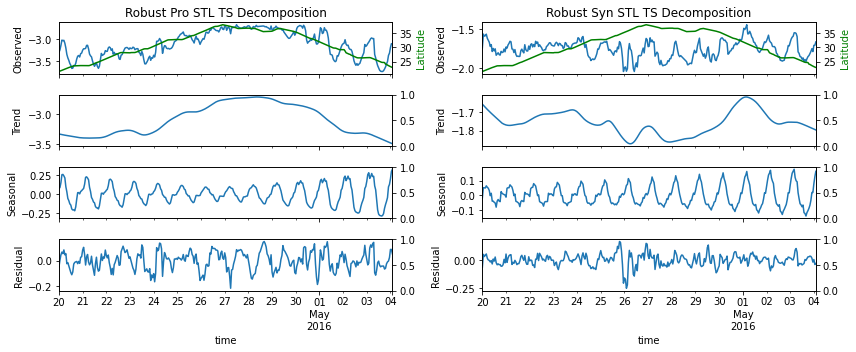

In [18]:
# Run robust STL to start with 
# No rolling (multiplicative)
period=24
robust_fit_pro = STL(np.log(pro_diam), period=period, robust=False, seasonal=15)
robust_fit_syn = STL(np.log(syn_diam), period=period, robust=False, seasonal=15)
robust_stl_pro = robust_fit_pro.fit()
robust_stl_syn = robust_fit_syn.fit()

fig, axes = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(12,5))
plotseasonal(robust_stl_pro, axes[:,0], pop='Robust Pro STL', lat=pro_res['lat'])
plotseasonal(robust_stl_syn, axes[:,1], pop='Robust Syn STL', lat=syn_res['lat'])
plt.tight_layout()

# print error
# print error
y_true=robust_stl_pro.observed
y_pred=robust_stl_pro.trend+robust_stl_pro.seasonal
rmse=mean_squared_error(y_true, y_pred,squared=False)
print(rmse)

In [21]:
pro_trend=np.exp(robust_stl_pro.trend.values.reshape(-1,1))
pro_res['trend']=pro_trend
syn_trend=np.exp(robust_stl_syn.trend.values.reshape(-1,1))
syn_res['trend']=syn_trend
pro_bkps=pelt_bkps(pro_trend, 'Prochlorococcus')
syn_bkps=pelt_bkps(syn_trend, 'Synechococcus')

In [26]:
# create unique breakpoints
pro_res['bkps']=make_bkps(pro_bkps)
syn_res['bkps']=make_bkps(syn_bkps)
# concatenate together
g1_all_bkps=pd.concat([pro_res,syn_res])

In [27]:
# calculate daily growth (daily hourly average)
g1_hourly,g1_avg_growth=calc_daily_hourly_growth(cruise_daily)

In [28]:
# merge bkps with growth data
growth_bkps=g1_all_bkps.reset_index()[['time','lat','lon','pop','trend','bkps']].merge(g1_hourly)
# find mean trend per change point
mean_bkps=growth_bkps.groupby(['pop','bkps']).agg({
    'trend':'mean'}).reset_index()
# rename col
mean_bkps.rename(columns={'trend':'mean_bkp'},inplace=True)
# merge with growth data
merge_bkps=growth_bkps.merge(mean_bkps)
# calculate productivity 
merge_bkps['prod']=merge_bkps['hourly_growth']*merge_bkps['mean_bkp']
# get daily mean
daily_rates=merge_bkps.groupby(['cruise_day','pop']).mean().reset_index()

In [29]:
# merge bkps with growth data
growth_bkps=g1_all_bkps.reset_index()[['time','lat','lon','pop','trend','bkps']].merge(g1_hourly)
# find mean trend per change point
mean_bkps=growth_bkps.groupby(['pop','bkps']).agg({
    'trend':'mean'}).reset_index()
# rename col
mean_bkps.rename(columns={'trend':'mean_bkp'},inplace=True)
# merge with growth data
merge_bkps=growth_bkps.merge(mean_bkps)
# calculate productivity 
merge_bkps['prod']=merge_bkps['hourly_growth']*merge_bkps['mean_bkp']
# get daily mean
daily_rates=merge_bkps.groupby(['cruise_day','pop']).mean().reset_index()

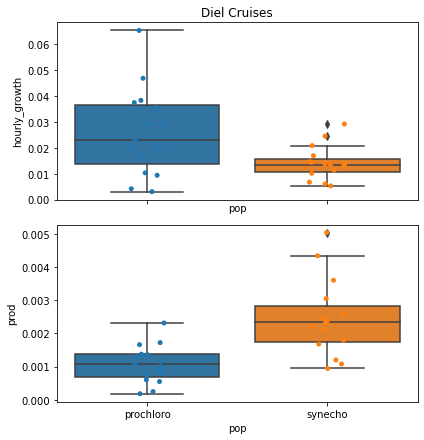

In [31]:
# make scattered box plot
fig,axs=plt.subplots(nrows=2,sharex=True, figsize=(6,6))
# creating boxplot 
sns.boxplot(x='pop', y='hourly_growth', data=daily_rates,ax=axs[0]) 
# adding data points 
ax=sns.stripplot(x='pop', y='hourly_growth', data=daily_rates,ax=axs[0]) 

# creating boxplot 
sns.boxplot(x='pop', y='prod', data=daily_rates,ax=axs[1]) 
# adding data points 
ax=sns.stripplot(x='pop', y='prod', data=daily_rates,ax=axs[1]) 
plt.tight_layout()
# add title
axs[0].set_title('Diel Cruises')
# display plot 
plt.show() 

## Functions here!

In [32]:
# function to run STL model
## input: cruise df
## output: pro_res = dataframe with cleaned tsd components for pro, syn_res=same but with syn
def run_STL(cruise):
    ## preliminary data cleaning 
    # run linear interpolation helper function to fill in missing data
    pro_res = interp_by_time(cruise, 'prochloro')
    syn_res = interp_by_time(cruise, 'synecho')

    # get data to run in model
    pro_diam=pro_res['diam_med']
    syn_diam=syn_res['diam_med']
    
    # Run robust STL to start with 
    # No rolling (multiplicative)
    period=24
    robust_fit_pro = STL(np.log(pro_diam), period=period, robust=False, seasonal=15)
    robust_fit_syn = STL(np.log(syn_diam), period=period, robust=False, seasonal=15)
    robust_stl_pro = robust_fit_pro.fit()
    robust_stl_syn = robust_fit_syn.fit()
    
    # add trend components to datasets
    pro_trend=np.exp(robust_stl_pro.trend.values.reshape(-1,1))
    pro_res['trend']=pro_trend
    syn_trend=np.exp(robust_stl_syn.trend.values.reshape(-1,1))
    syn_res['trend']=syn_trend
    # return both components
    return pro_res,syn_res

In [33]:
# first detect by using raw data- use PELT (unknown # breakpoints)
def pelt_bkps(trend,pop,make_graph=False):
    # calculate penalty by BIC
    T, d = trend.shape  # number of samples, dimension
    sigma = np.std(trend)  # noise standard deviation
    bic = (2*sigma**2)*np.log(T)*(d+1)

    algo = rpt.Pelt(model="l2", min_size=24)
    algo.fit(trend)
    result = algo.predict(pen=bic)
    if make_graph:
        rpt.display(trend ,result, figsize=(10,4))
        plt.title(f'{pop} Trend QC Change Point Detection')
        plt.xlabel('Time Index')
        plt.ylabel('Qc (pG C/cell)')
        plt.show()
        plt.rcParams.update({"font.size":15})
    return(result)

In [34]:
## helper function to create breakpoints in dataframe
def make_bkps(bkps):
    bkps=bkps.copy()
    # init vars
    index=0
    # first add 0 to the beginning of bkps if not already there
    if (bkps[index]!=0):
        bkps.insert(0,0)
    # generate change points list
    segments=[]
    for pt in bkps:
        ## if at the end, end loop
        if pt==bkps[-1]:
            break
        # impossible to start at beginning as min_size = 24, no need for that edge case (famous last words lol)
        else:
            # make second segment
            num_bkps=bkps[index+1]-pt
            seg=np.repeat(index, num_bkps)
            segments.append(seg)
            index+=1
    return np.concatenate(segments).ravel().tolist()

In [35]:
def calc_growth_prod(cruise):
    # run STL tsd to get trend components
    name=pd.unique(cruise.cruise)[0]
    pro_res, syn_res=run_STL(cruise)
    # get breakpoints from PELT algorithm
    pro_bkps=pelt_bkps(pro_res.trend.values.reshape(-1,1), 'Prochlorococcus')
    syn_bkps=pelt_bkps(syn_res.trend.values.reshape(-1,1), 'Synechococcus')
    # define unique breakpoints in df
    pro_res['bkps']=make_bkps(pro_bkps)
    syn_res['bkps']=make_bkps(syn_bkps)
    # concatenate together
    all_bkps=pd.concat([pro_res,syn_res])

    # calculate growth
    hourly=calc_daily_hourly_growth(cruise)[0]

    # merge bkps with growth data
    growth_bkps=all_bkps.reset_index()[['time','lat','lon','pop','trend','bkps','temp']].merge(hourly)
    # find mean trend per change point
    mean_bkps=growth_bkps.groupby(['pop','bkps']).agg({
        'trend':'mean'}).reset_index()
    # rename col
    mean_bkps.rename(columns={'trend':'mean_bkp'},inplace=True)
    # merge with growth data
    merge_bkps=growth_bkps.merge(mean_bkps)
    # calculate productivity 
    merge_bkps['prod']=merge_bkps['hourly_growth']*merge_bkps['mean_bkp']
    # get daily mean
    daily_rates=merge_bkps.groupby(['cruise_day','pop']).mean().reset_index()
    daily_rates['cruise']=name
    # throw out the negative ones
    return daily_rates.loc[daily_rates['hourly_growth']>0]

In [36]:
def rates_box_plot(df,title):
    # make scattered box plot
    fig,axs=plt.subplots(nrows=2,sharex=True, figsize=(8,7))
    # creating boxplot 
    sns.boxplot(x='pop', y='hourly_growth', data=df,ax=axs[0]) 
    # adding data points 
    sns.stripplot(x='pop', y='hourly_growth', data=df,ax=axs[0]) 
    axs[0].ylabel='Daily Averaged Hourly Growth (-hour)'
    axs[0].set_ylim(0,0.12)
    

    # creating boxplot 
    sns.boxplot(x='pop', y='prod', data=df,ax=axs[1]) 
    # adding data points 
    sns.stripplot(x='pop', y='prod', data=df,ax=axs[1])
    axs[1].ylabel='Daily Averaged Hourly Productivity (pg C/cell*hour)'
    axs[1].set_ylim(0,0.022)
    plt.tight_layout()
    # add title
    axs[0].set_title(title)
    # display plot 
    plt.show() 

In [38]:
# all cruises
cruise_list = [all_cruises.loc[all_cruises['cruise']==n] for n in pd.unique(all_cruises['cruise'])]
all_names = pd.unique(all_cruises['cruise'])
# run for gradient cruise and diel cruise
gradients = ['SCOPE_16','MGL1704','KM1906','TN397_740']
gradients_list = [all_cruises.loc[all_cruises['cruise']==n] for n in gradients]
gradients_names = ['G1','G2','G3','G4']
# diel cruises
diel=['SCOPE_6', 'MESO_SCOPE']
diel_names=['Diel_2015', 'meso_scope']
diel_list = [all_cruises.loc[all_cruises['cruise']==n] for n in diel]
# hot cruises
HOT_mask=all_cruises['cruise'].str.startswith('HOT')
HOT_cruises=all_cruises.loc[HOT_mask]
HOT_names=pd.unique(HOT_cruises.cruise).tolist()
HOT_cruises_list=[HOT_cruises.loc[HOT_cruises['cruise']==n] for n in HOT_names]

In [39]:
all_rates=[]
# run for all cruises first
for cruise,name in zip(cruise_list,all_names):
    print(name)
    try:
        rates=calc_growth_prod(cruise)
    except:
        continue
    all_rates.append(rates)

DeepDOM
HOT-294
HOT297
HOT299
HOT301
HOT302
HOT303
HOT304
HOT307
HOT308
HOT309
HOT310
HOT312
HOT313
HOT314
HOT315
HOT317
HOT318
HOT319
HOT321
HOT322
HOT323
HOT324
HOT325
HOT326
KM1712
KM1713
KM1906
KM1923_751
KOK1806
MBARI_1
MBARI_2
MBARI_3
MESO_SCOPE
MGL1704
SCOPE_1
SCOPE_10
SCOPE_11
SCOPE_12
SCOPE_13
SCOPE_14
SCOPE_15
SCOPE_16
SCOPE_17
SCOPE_18
SCOPE_19
SCOPE_2
SCOPE_3
SCOPE_4
SCOPE_5
SCOPE_6
SCOPE_9
SCOPE_Falkor1
SCOPE_Falkor2
SCOPE-PARAGON
SR1917
Thompson_1
Thompson_10
Thompson_12
Thompson_9
TN397_740
TN398
Tokyo_3


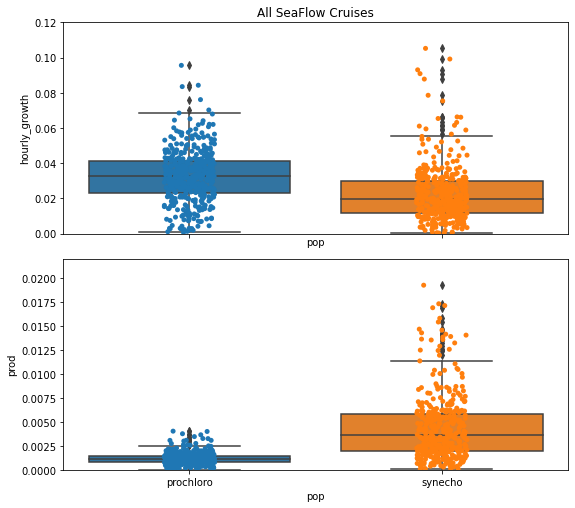

In [40]:
all_rates_df=pd.concat(all_rates)
# toss out some outliers
all_rates_df=all_rates_df.loc[all_rates_df['prod']<0.04]
title='All SeaFlow Cruises'
rates_box_plot(all_rates_df, title)

In [143]:
# create temp bins
def custom_round(x, base=5):
    return int(base * round(float(x)/base))

rates_temp=all_rates_df.loc[all_rates_df['temp'].notnull()]
rates_temp['round_temp']=rates_temp['temp'].apply(lambda x: custom_round(x, base=2))

# calculate top 20% per bin
rates_temp['top_growth']='Below'
rates_temp.loc[rates_temp['hourly_growth'] >= rates_temp.groupby(['pop',
                                                              'round_temp'])['hourly_growth'].transform('quantile',
                                                                                                        0.8),
              'top_growth']='Above'
# do same for productivity
rates_temp['top_prod']='Below'
rates_temp.loc[rates_temp['prod'] >= rates_temp.groupby(['pop',
                                                              'round_temp'])['prod'].transform('quantile',
                                                                                                        0.8),
              'top_prod']='Above'

px.scatter(rates_temp, x='temp',y='prod',facet_row='pop',color='top_prod')

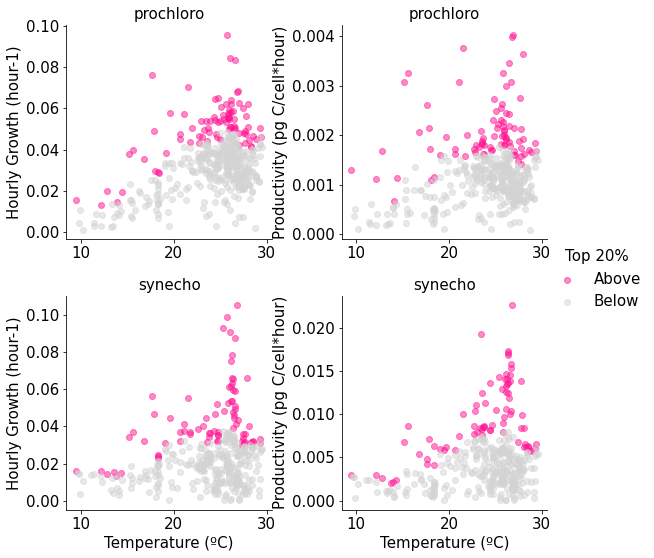

In [161]:
# melt for hourly and productivity values
melt_dat = pd.melt(rates_temp, id_vars=['cruise_day','pop','cruise','temp','lat'], 
               value_vars=['hourly_growth', 'prod'],
    var_name='var', value_name='val')
# melt for the top hourly vals each
melt2=pd.melt(rates_temp, id_vars=['cruise_day','pop','cruise','temp','lat'], 
               value_vars=['top_growth', 'top_prod'],
    var_name='top_rate', value_name='Top 20%')

id_vars=['cruise_day','pop','cruise','temp','lat']
df1=melt_dat.set_index(['cruise_day','pop','cruise','temp','lat', 
                    melt_dat.groupby(id_vars).cumcount()])
df2=melt2.set_index(['cruise_day','pop','cruise','temp','lat', 
                         melt2.groupby(id_vars).cumcount()])


df3=(pd.concat([df1, df2],axis=1)
         .sort_index(level=2)
         .reset_index(level=2, drop=True)
         .reset_index())


fig = sns.lmplot(
data=df3, x="temp", y="val", row="pop", col='var', palette=["deeppink","lightgrey"],
    height=4, sharey=False, sharex=False, hue='Top 20%', fit_reg=False,scatter_kws={'alpha':0.5})
# fig.set(ylim=(0, 0.12))
# set labels
fig.axes[1,1].set_xlabel('Temperature (ºC)')
fig.axes[1,0].set_xlabel('Temperature (ºC)')
fig.axes[0,0].set_ylabel('Hourly Growth (hour-1)')
fig.axes[0,1].set_ylabel('Productivity (pg C/cell*hour)')
fig.axes[1,0].set_ylabel('Hourly Growth (hour-1)')
fig.axes[1,1].set_ylabel('Productivity (pg C/cell*hour)')
[plt.setp(ax.texts, text="") for ax in fig.axes.flat] 
fig.set_titles('{row_name}')
plt.rcParams.update({'font.size':15})

In [129]:
# pop_names=np.repeat('prochloro',len(pro_trend)).tolist()
# pop_names.extend(np.repeat('synecho',len(syn_trend)))
# trends=np.concatenate([pro_trend,syn_trend]).ravel()
# len(pop_names)